In [4]:
import os

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize

import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, 'r', driver = 'JP2OpenJPEG') as src:
    raster_img = src.read()
    raster_meta = src.meta

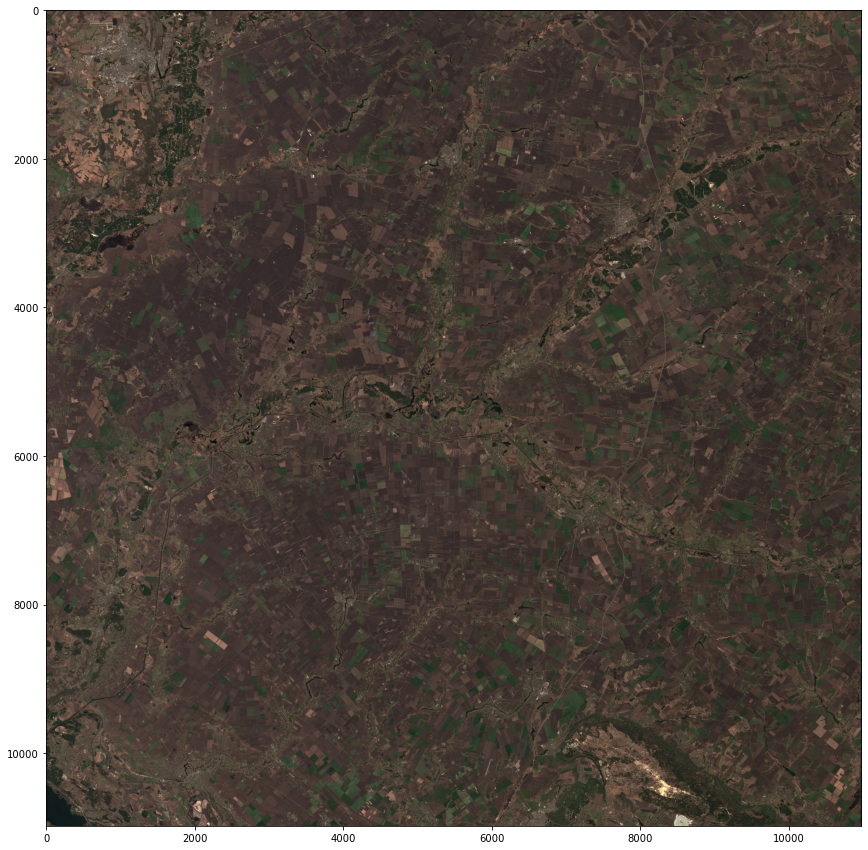

In [6]:
raster_img = reshape_as_image(raster_img)

plt.figure(figsize=(15,15))
plt.imshow(raster_img)

In [7]:
train_df = gpd.read_file("masks/Masks_T36UXV_20190427.shp")
print(len(train_df))
train_df.head(5)

936


,id,Data,Code,Descriptio,Comments,Image,geometry
0,None,None,2.0,branch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.62916 49.60293, 35.63015 49.60163..."
1,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.65070 49.60254, 35.65248 49.60301..."
2,None,None,2.0,brahch of tree,None,T36UXV_20190427T083601,"POLYGON ((35.63023 49.60826, 35.62960 49.60920..."
3,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.62033 49.60905, 35.62064 49.60968..."
4,None,None,1.0,color+ feathers,None,T36UXV_20190427T083601,"POLYGON ((35.60455 49.61078, 35.60597 49.61228..."


In [8]:
train_df['geometry'][0].exterior.coords.xy

(array('d', [35.62916346617293, 35.63014960535702, 35.631175190108465, 35.631214635675825, 35.630031268654925, 35.62888734720139, 35.62813788142149, 35.62774342574785, 35.62813788142149, 35.62916346617293]),
 array('d', [49.602931546762534, 49.60162984303954, 49.60080148612491, 49.59981534694083, 49.6001703570471, 49.60111705066382, 49.60214263541526, 49.60289210119517, 49.60312877459935, 49.602931546762534]))

In [9]:
train_df = gpd.read_file("masks/Masks_T36UXV_20190427.shp")


# let's remove rows without geometry
train_df = train_df[train_df.geometry.notnull()]

# assigning crs
train_df.crs = {'init' :'epsg:4324'}

#transforming polygons to the raster crs
train_df = train_df.to_crs({'init' : raster_meta['crs']['init']})

C:\Users\Andrey\anaconda3\envs\ev_2\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


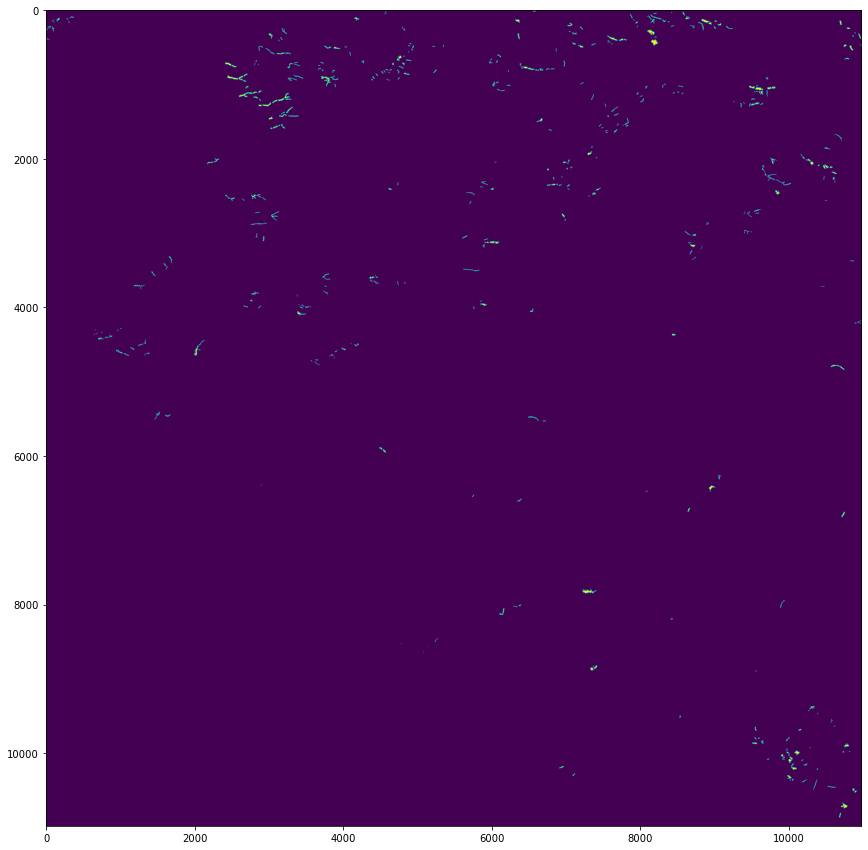

In [10]:
# rasterize works with polygons that are in image coordinate system

def poly_from_utm(polygon, transform):
    poly_pts = []
    
    # make a polygon from multipolygon
    poly = cascaded_union(polygon)
    for i in np.array(poly.exterior.coords):
        
        # transfrom polygon to image crs, using raster meta
        poly_pts.append(~transform * tuple(i))
        
    # make a shapely Polygon object
    new_poly = Polygon(poly_pts)
    return new_poly

# creating binary mask for field/not_filed segmentation.

poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in train_df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly = poly_from_utm(row['geometry'], src.meta['transform'])
        poly_shp.append(poly)
    else:
        for p in row['geometry']:
            poly = poly_from_utm(p, src.meta['transform'])
            poly_shp.append(poly)

mask = rasterize(shapes=poly_shp,
                 out_shape=im_size)

# plotting the mask

plt.figure(figsize=(15,15))
plt.imshow(mask)

In [ ]:
bin_mask_meta = src.meta.copy()
bin_mask_meta.update({'count': 1})
with rasterio.open('big_mask.jp2", 'w', **bin_mask_meta) as dst:
    dst.write(mask * 255, 1)

# Crop

In [55]:
raster_path = 'T36UXV_20200406T083559_TCI_10m.jp2'
with rasterio.open(raster_path, 'r', driver = 'JP2OpenJPEG') as src:
    big_img = src.read()
    img_meta = src.meta

raster_path = 'big_mask.jp2'
with rasterio.open(raster_path, 'r', driver = 'JP2OpenJPEG') as src:
    big_mask = src.read()
    mask_meta = src.meta

In [56]:
big_img = reshape_as_image(big_img)
big_mask = reshape_as_image(big_mask)

c_img_path = "cropped_img_256"
c_mask_path = "cropped_mask_256"

def crop_img(big_img, shape, outfolder):
    i = 0
    for r in range(0,big_img.shape[0],shape[0]):
        for c in range(0,big_img.shape[1],shape[1]):
            img_path = os.path.join(outfolder, f'{i}.png')
            if r+shape[0] <= big_img.shape[0] and c + shape[1] <= big_img.shape[1]:
                cv2.imwrite(img_path, cv2.cvtColor(big_img[r:r+shape[0], c:c+shape[1],:], cv2.COLOR_RGB2BGR))
                i += 1
                
crop_img(big_img, (256, 256), c_img_path)
crop_img(big_mask, (256, 256), c_mask_path)

c_img_path = "cropped_img_512"
c_mask_path = "cropped_mask_512"

crop_img(big_img, (512, 512), c_img_path)
crop_img(big_mask, (512, 512), c_mask_path)

# EDA

In [79]:
def extract_imgs(TRAIN_DIR, MASK_DIR, train_list, mask_list, mode = 'limited'):
    out_rgb = []
    out_mask = []

    counter_empty = 0

    for p_img, p_mask in zip(train_list, mask_list):   
        img_path = os.path.join(TRAIN_DIR, p_img)
        mask_path = os.path.join(MASK_DIR, p_mask)
    
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.
        mask = cv2.imread(mask_path)
    
        mask = mask[:, :, :1]
        mask[mask > 0.] = 1.
        
        if mode == 'limited':
            if 1 not in mask: counter_empty+=1
    
            if not(1 not in mask and counter_empty >= 40):
                out_rgb += [img]
                out_mask += [mask]
        elif mode == 'not_limited':
            if 1 not in mask: counter_empty+=1
            out_rgb += [img]
            out_mask += [mask]
        

    out_rgb = np.array(out_rgb, dtype = 'float32')
    out_mask = np.array(out_mask, dtype = 'float32')
    if mode == 'limited':
        return out_rgb, out_mask
    if mode == 'not_limited':
        return out_rgb, out_mask, counter_empty

BASE_DIR = ''
TRAIN_DIR = BASE_DIR + 'cropped_img_256/'
MASK_DIR = BASE_DIR + 'cropped_mask_256/'

train = os.listdir(TRAIN_DIR)
mask = os.listdir(MASK_DIR)

print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(mask)}. ---> {mask[:3]}")

all_rgb_256, all_mask_256, c_256 = extract_imgs(TRAIN_DIR, MASK_DIR, train, mask, mode = 'not_limited')
rgb_256, mask_256 = extract_imgs(TRAIN_DIR, MASK_DIR, train, mask, mode = 'limited')

TRAIN_DIR = BASE_DIR + 'cropped_img_512/'
MASK_DIR = BASE_DIR + 'cropped_mask_512/'

train = os.listdir(TRAIN_DIR)
mask = os.listdir(MASK_DIR)

print(f"Train files: {len(train)}. ---> {train[:3]}")
print(f"Test files :  {len(mask)}. ---> {mask[:3]}")

all_rgb_512, all_mask_512, c_512 = extract_imgs(TRAIN_DIR, MASK_DIR, train, mask, mode = 'not_limited')
rgb_512, mask_512 = extract_imgs(TRAIN_DIR, MASK_DIR, train, mask, mode = 'limited')

Train files: 1764. ---> ['0.png', '1.png', '10.png']
Test files :  1764. ---> ['0.png', '1.png', '10.png']
Train files: 441. ---> ['0.png', '1.png', '10.png']
Test files :  441. ---> ['0.png', '1.png', '10.png']


## Pixel ratio

In [81]:
print(f"All 256: {all_rgb_256.shape[0]}. ---> Empty: {c_256}")
print(f"All 512:  {all_rgb_512.shape[0]}. ---> Empty {c_512}")

All 256: 1764. ---> Empty: 1500
All 512:  441. ---> Empty 306


In [82]:
def pixel_ratio(masks):
    ratio = []
    for mask in masks:
        ratio.append(mask[mask>0].shape[0] /  (masks.shape[0]*masks.shape[1]))
    return np.average(ratio)

all_ratio_256 = pixel_ratio(all_mask_256)
ratio_256 = pixel_ratio(mask_256)
all_ratio_512 = pixel_ratio(all_mask_512)
ratio_512 = pixel_ratio(mask_512)

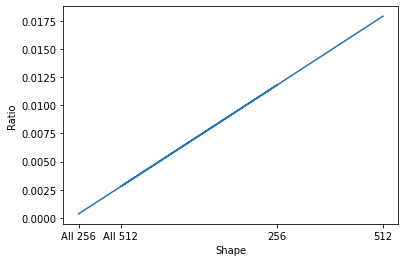

In [84]:
x = np.array([all_ratio_256,ratio_256, all_ratio_512, ratio_512])
y = np.array([all_ratio_256,ratio_256, all_ratio_512, ratio_512])
xticks = ['All 256','256', 'All 512','512']
plt.xticks(x, xticks)
plt.xlabel('Shape')
plt.ylabel('Ratio')
plt.plot(x, y)
plt.show()

## Masks problem

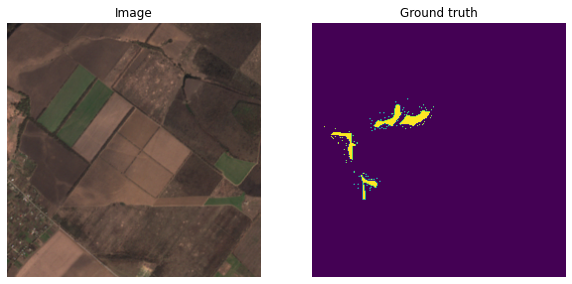

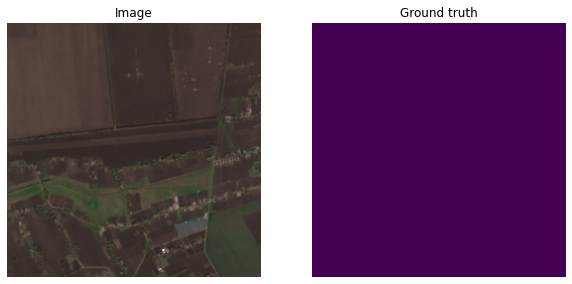

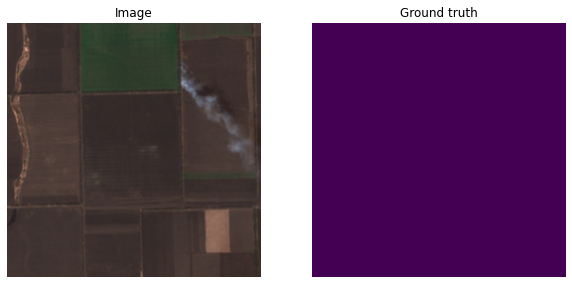

In [123]:
rows = 1
columns = 2

images_id = [1, 27, 32]
for i in images_id:
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(rgb_256[i])
    plt.axis('off')
    plt.title("Image")
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(mask_256[i], interpolation=None)
   
    plt.axis('off')
    plt.title("Ground truth")